# Bass Matching Demo with Colored Notation

This notebook demonstrates the `percent_bass_pc_match` function from `music_df.harmony.matching`,
with **colored notation** to visually highlight which bass notes match their expected pitch classes.

- **Green** bass notes: match the expected bass PC (root position)
- **Red** bass notes: don't match the expected bass PC (inverted)

In [1]:
import sys
from pathlib import Path
sys.path.insert(0, str(Path.cwd().parent))

In [2]:
import io

import verovio
from IPython.display import SVG, display
import pandas as pd

from music_df.humdrum_export import df2hum
from music_df.harmony.matching import percent_bass_pc_match

In [3]:
MATCH_COLOR = "#00AA00"  # Green for matching bass
NO_MATCH_COLOR = "#DD0000"  # Red for non-matching bass


def show_bass_matching(result_df: pd.DataFrame, width: int = 800, scale: int = 50) -> None:
    """Convert result DataFrame to colored notation and display it."""
    result_df = result_df.copy()
    result_df["color"] = result_df["is_bass_match"].map({True: "match", False: "no_match"})
    result_df["is_bass"] = result_df["is_bass_match"].notna()

    humdrum = df2hum(
        result_df,
        color_col="color",
        color_mask_col="is_bass",
        color_mapping={"match": MATCH_COLOR, "no_match": NO_MATCH_COLOR},
    )

    tk = verovio.toolkit()
    tk.setOptions({"pageWidth": width, "scale": scale, "adjustPageHeight": True})
    tk.loadData(humdrum)
    for page in range(1, tk.getPageCount() + 1):
        display(SVG(tk.renderToSVG(page)))

## Example 1: Root Position Chords (100% bass match)

C major (C-E-G) and G major (G-B-D) triads in root position.
Bass notes C and G match their expected PCs, so they appear **green**.

Bass match rate: 100%


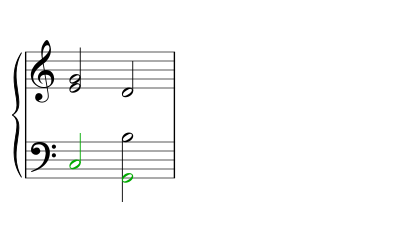

In [4]:
music_df1 = pd.read_csv(io.StringIO('''
type,pitch,onset,release,spelling
bar,,0.0,,
note,48,0.0,2.0,C
note,64,0.0,2.0,E
note,67,0.0,2.0,G
note,43,2.0,4.0,G
note,59,2.0,4.0,B
note,62,2.0,4.0,D
bar,,4.0,,
'''))

chord_df1 = pd.DataFrame({
    "onset": [0.0, 2.0],
    "release": [2.0, 4.0],
    "chord_pcs": ["047", "72B"],  # C major (bass=C), G major (bass=G)
})

result1 = percent_bass_pc_match(music_df1, chord_df1)
print(f"Bass match rate: {result1['microaverage']:.0%}")
show_bass_matching(result1["music_df"])

## Example 2: Inverted Chords (0% bass match)

Same C major and G major chords, but in first inversion.
Bass notes E and B don't match expected PCs (0 and 7), so they appear **red**.

Bass match rate: 0%


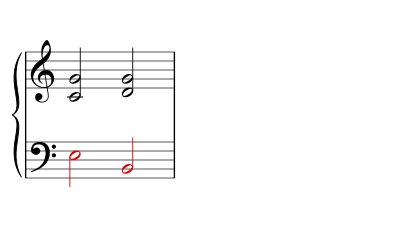

In [5]:
music_df2 = pd.read_csv(io.StringIO('''
type,pitch,onset,release,spelling
bar,,0.0,,
note,52,0.0,2.0,E
note,60,0.0,2.0,C
note,67,0.0,2.0,G
note,47,2.0,4.0,B
note,62,2.0,4.0,D
note,67,2.0,4.0,G
bar,,4.0,,
'''))

chord_df2 = pd.DataFrame({
    "onset": [0.0, 2.0],
    "release": [2.0, 4.0],
    "chord_pcs": ["047", "72B"],  # Same chords, but music is inverted
})

result2 = percent_bass_pc_match(music_df2, chord_df2)
print(f"Bass match rate: {result2['microaverage']:.0%}")
show_bass_matching(result2["music_df"])

## Example 3: Mixed (Partial match)

First chord in root position (bass matches → green),
second chord inverted (bass doesn't match → red).

Bass match rate: 50%


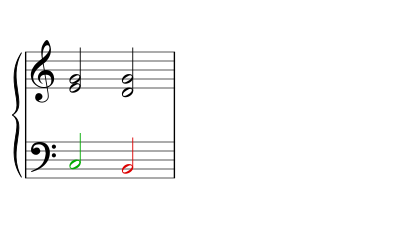

In [6]:
music_df3 = pd.read_csv(io.StringIO('''
type,pitch,onset,release,spelling
bar,,0.0,,
note,48,0.0,2.0,C
note,64,0.0,2.0,E
note,67,0.0,2.0,G
note,47,2.0,4.0,B
note,62,2.0,4.0,D
note,67,2.0,4.0,G
bar,,4.0,,
'''))

chord_df3 = pd.DataFrame({
    "onset": [0.0, 2.0],
    "release": [2.0, 4.0],
    "chord_pcs": ["047", "72B"],
})

result3 = percent_bass_pc_match(music_df3, chord_df3)
print(f"Bass match rate: {result3['microaverage']:.0%}")
show_bass_matching(result3["music_df"])

## Example 4: Duration Weighting Demo

Two bass notes within a single chord:
- C (matching) held for 3 beats → green
- D (non-matching) held for 1 beat → red

With duration weighting: 3/(3+1) = 75%
Without duration weighting: 1/2 = 50%

With duration weighting:    75%
Without duration weighting: 50%


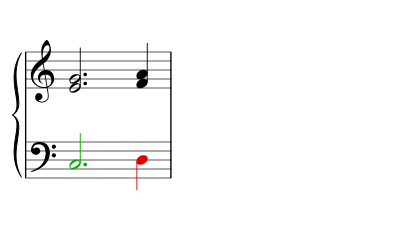

In [7]:
music_df4 = pd.read_csv(io.StringIO('''
type,pitch,onset,release,spelling
bar,,0.0,,
note,48,0.0,3.0,C
note,64,0.0,3.0,E
note,67,0.0,3.0,G
note,50,3.0,4.0,D
note,65,3.0,4.0,F
note,69,3.0,4.0,A
bar,,4.0,,
'''))

chord_df4 = pd.DataFrame({
    "onset": [0.0],
    "release": [4.0],
    "chord_pcs": ["047"],  # C major expected throughout
})

result4_weighted = percent_bass_pc_match(music_df4, chord_df4, weight_by_duration=True)
result4_unweighted = percent_bass_pc_match(music_df4, chord_df4, weight_by_duration=False)

print(f"With duration weighting:    {result4_weighted['microaverage']:.0%}")
print(f"Without duration weighting: {result4_unweighted['microaverage']:.0%}")
show_bass_matching(result4_weighted["music_df"])

## Summary

The `percent_bass_pc_match` function:
1. Identifies bass notes (lowest pitch at each onset)
2. Checks if each bass note's pitch class matches the expected bass PC (first char of `chord_pcs`)
3. Returns match rates and adds `is_bass_match` column to the DataFrame

Using `df2hum` with color mapping:
- `color_col`: column containing color category ("match" or "no_match")
- `color_mask_col`: boolean column for which notes to color (True = bass notes)
- `color_mapping`: dict mapping categories to hex colors